# VarClump2D: Concept test

## _Without optimizations..._

In [2]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
from math import sqrt, floor, ceil
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

## Helper functions

In [3]:
"""
Helper function to visualize the quality of the solution
"""
def plotter(c, sig, xc, resolution=10, title=None):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_), 'b--', label='Data')
    plt.plot(xe, f(xe), 'go', label='Evaluation points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

## Loading data 2D: Stacking on frequency

In [4]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
#cont.load('../../bindata/fits/cubes/M100line.image.fits')
cont.load('../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')
#cont.load('../../bindata/fits/cubes/ALMA01000740.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.stack(axis=(0))
data /= data.max()

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [122]:
"""
Generating the data function
"""
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
f = sp.interpolate.interp2d(x, y, data, kind='linear')

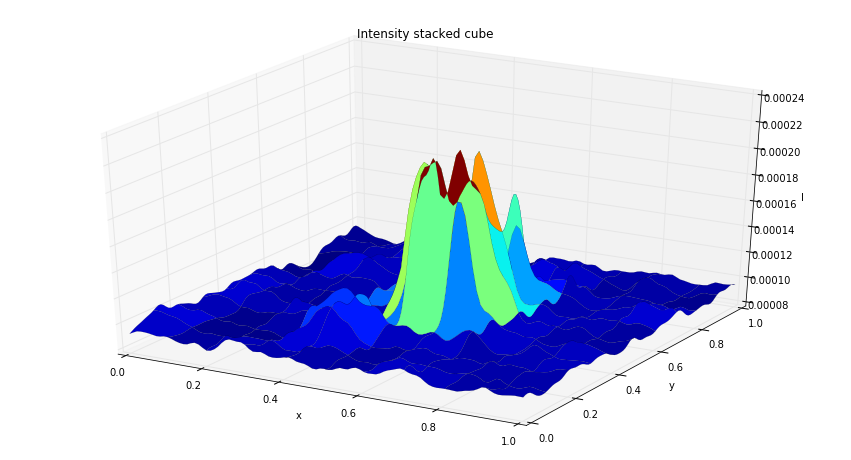

In [123]:
X,Y = np.meshgrid(x,y,sparse=True)
#3d plot
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('I')
plt.title('Intensity stacked cube')
plt.show()

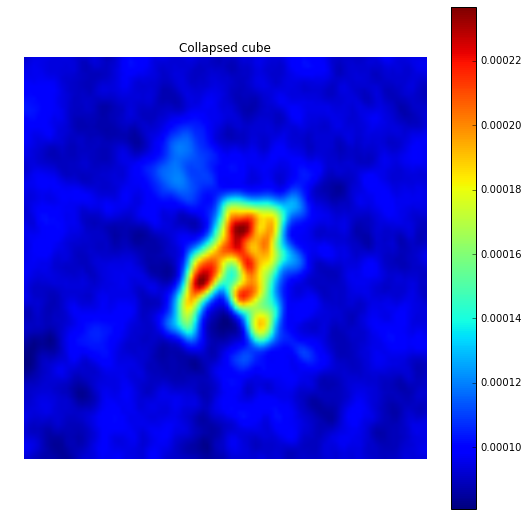

In [125]:
plt.figure(figsize=(9,9))
plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
plt.colorbar()
plt.show()

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}=$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$ (will be the same)

In [126]:
"""
General Psi penalizing function (applicable in both cases)
"""
def psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('10*x**3 - 15*x**4 + 6*x**5')
    return ret

def d1psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('30*x**2 - 60*x**3 + 30*x**4')
    return lamb*ret

def d2psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('60*x - 180*x**2 + 120*x**3')
    return (lamb**2)*ret

## $\phi$-RBF function to use and its derivatives

In [127]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, y, sig):
    retval = ne.evaluate('exp(-(x**2+y**2)/(2*sig**2))')
    return retval

def phix(x, y, sig):
    retval = ne.evaluate('(-1./sig**2) * exp(-(x**2+y**2)/(2*sig**2)) * x')
    return retval

def phiy(x, y, sig):
    retval = ne.evaluate('(-1./sig**2) * exp(-(x**2+y**2)/(2*sig**2)) * y')
    return retval

#same as phiyx
def phixy(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (x*y)')
    return retval

def phixx(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (x**2 - sig**2)')
    return retval

def phiyy(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (y**2 - sig**2)')
    return retval

## Euler-Lagrange function class definition

In [128]:
class ELFunc():
    def __init__(self, f, xe, ye, xc, yc, xb, yb, c0, sig0, d1psi1=None, 
                 d1psi2=None, d2psi2=None, a=0., b=0., lamb1=1., lamb2=1.):
        #data function at evaluation and boundary points
        f0 = f(xe,ye).ravel()
        fb = np.array([f(xb[i],yb[i]) for i in range(len(xb))]).ravel()
        len_f0 = len(f0)
        len_xe = len(xe); len_ye = len(ye)
        len_xc = len(xc); len_yc = len(yc)
        len_xb = len(xb); len_yb = len(yb)
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        """
        TODO:verify consistency
        """
        #if len_c0 != len_sig0: 
        #    print('Dimensions of c0 and sig0 must match!')
        #    return None
        #if (shape_Dx[0]+2 != shape_Dx[1]) or (shape_Dx[1] != len_c0):
        #    print('Dimensions of Dx are wrong!')
        #    return None
        """ 
        Computing distance matrices
        """
        Dx = np.empty((len_xe,len_xc))
        Dy = np.empty((len_ye,len_yc))
        for k in range(len_xe):
            Dx[k,:] = (xe[k]-xc)
        for k in range(len_ye):
            Dy[k,:] = (ye[k]-yc)
            
        """
        Computing the Phi-matrices
        """
        sig0 = sig0.reshape(len_xc, len_yc)
        r_index = 0
        Ne = len_xe*len_ye
        Nc = len_xc*len_yc
        phi_m = np.empty((Ne,Nc))
        phix_m = np.empty((Ne,Nc))
        phiy_m = np.empty((Ne,Nc))
        phixx_m = np.empty((Ne,Nc))
        phiyy_m = np.empty((Ne,Nc))
        phixy_m = np.empty((Ne,Nc))
        for i in range(len_ye):
            for j in range(len_xe):
                dx,dy = np.meshgrid(Dx[j,:], Dy[i,:], sparse=True)
                phi_m[r_index,:] = phi(dx,dy,sig0).ravel()
                phix_m[r_index,:] = phix(dx,dy,sig0).ravel()
                phiy_m[r_index,:] = phiy(dx,dy,sig0).ravel()
                phixx_m[r_index,:] = phixx(dx,dy,sig0).ravel()
                phiyy_m[r_index,:] = phiyy(dx,dy,sig0).ravel()
                phixy_m[r_index,:] = phixy(dx,dy,sig0).ravel()
                r_index += 1
        
        """
        Center positions in full format
        """
        Xc,Yc = np.meshgrid(xc,yc)
        Xc = Xc.ravel(); Yc = Yc.ravel()
        
        """
        Storing important atributes
        """
        self.f0 = f0
        self.fb = fb
        self.xe = xe; self.ye = ye
        self.xc = xc; self.yc = yc
        self.Xc = Xc; self.Yc = Yc
        self.xb = xb; self.yb = yb
        self.Dx = Dx
        self.Dy = Dy
        self.phi_m = phi_m; self.buff_phi_m = phi_m
        self.phix_m = phix_m; self.buff_phix_m = phix_m
        self.phiy_m = phiy_m; self.buff_phiy_m = phiy_m
        self.phixx_m = phixx_m; self.buff_phixx_m = phixx_m
        self.phiyy_m = phiyy_m; self.buff_phiyy_m = phiyy_m
        self.phixy_m = phixy_m; self_buff_phixy_m = phixy_m
        self.c = c0
        self.sig = sig0.ravel()
        self.d1psi1 = d1psi1
        self.d1psi2 = d1psi2
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        
    def set_c(self, c):
        #self.c = c
        pass
    
    def set_sig(self, sig):
        pass
    
    def F(self, X):
        N = len(X)/2
        c_squared = X[0:N]**2
        sig = X[N:]
        
        """
        Computing the Phi-matrices
        """
        phi_m = self.phi_m**(self.sig**2/sig**2)
        phix_m = self.phix_m**(self.sig**2/sig**2)
        phiy_m = self.phiy_m**(self.sig**2/sig**2)
        phixx_m = self.phixx_m**(self.sig**2/sig**2)
        phiyy_m = self.phiyy_m**(self.sig**2/sig**2)
        phixy_m = self.phixy_m**(self.sig**2/sig**2)
        
        """
        Computing u, ux, uy, ...
        """
        u = np.dot(phi_m, c_squared)
        ux = np.dot(phix_m, c_squared)
        uy = np.dot(phiy_m, c_squared)
        uxx = np.dot(phixx_m, c_squared)
        uyy = np.dot(phiyy_m, c_squared)
        uxy = np.dot(phixy_m, c_squared)
        
        """
        Computing the EL equation
        """
        """el = 2.*(u-self.f0) + \
            self.a*self.d1psi1(u-self.f0, self.lamb1) - \
            2*self.b*(2*self.d2psi2(ux**2 + uy**2, self.lamb2) * ((ux*uxx + uy*uxy)*ux + (ux*uxy + uy+uyy)*uy) + \
                      self.d1psi2(ux**2 + uy**2, self.lamb2)*(uxx + uyy))"""
        el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        
        """
        Boundary conditions
        """
        bc = [np.dot(phi(self.xb[i]-self.Xc, self.yb[i]-self.Yc,sig),c_squared)-self.fb[i] for i in range(len(self.xb))]
        bc = np.asarray(bc)
        return np.concatenate([el,bc])

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

## Centers and evaluation points

In [160]:
#must be square if regular grid is used
Nx = 15
Ny = 15
N = Nx*Ny
#number of boundary points by side
Nb = 3

"""
(Interior) Center points
"""
xc = np.linspace(0., 1., Nx+2)[1:-1]
yc = np.linspace(0., 1., Ny+2)[1:-1]

"""
(Interior) Evaluation points
"""
xe = np.linspace(0., 1., int(ceil(sqrt(2)*Nx))+2)[1:-1]
ye = np.linspace(0., 1., int(ceil(sqrt(2)*Ny))+2)[1:-1]

"""
Boundary points
"""
xb = []
yb = []
for jv in [0,1]:
    for iv in np.linspace(0., 1., Nb+2)[1:-1]:
        xb.append(iv)
        yb.append(jv)
for iv in [0,1]:
    for jv in np.linspace(0., 1., Nb+2)[1:-1]:
        xb.append(iv)
        yb.append(jv)
xb = np.asarray(xb)
yb = np.asarray(yb)

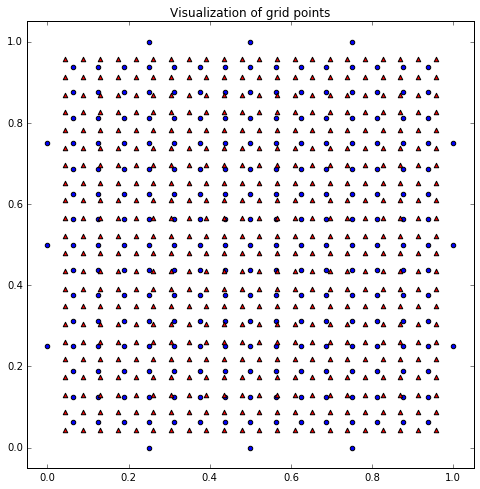

In [161]:
Xc,Yc = np.meshgrid(xc,yc)
Xe,Ye = np.meshgrid(xe,ye)
plt.figure(figsize=(8,8))
plt.scatter(xb, yb, marker='o', c='b', s=20)
plt.scatter(Xc.ravel(), Yc.ravel(), marker='o', c='b', s=20)
plt.scatter(Xe.ravel(), Ye.ravel(), marker='^', c='r', s=20)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.title("Visualization of grid points")
plt.show()

## Initial Conditions

In [162]:
"""
Defining initial parameter values
"""
c0 = f(xc,yc).ravel()/N
sig0 = (1./(N))*np.ones(N)

## Solving it!

In [163]:
elf = ELFunc(f, xe, ye, xc, yc, xb, yb, c0, sig0, d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi)

In [164]:
#elf.F(np.concatenate([c0,sig0]))

In [165]:
sol = sp.optimize.root(elf.F, np.concatenate([elf.c, elf.sig]), method='lm', options={'maxiter':10000})
opt_c = sol.x[0:N]
opt_sig = sol.x[N:]

/home/martin/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:105: RuntimeWarning: invalid value encountered in power
/home/martin/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:106: RuntimeWarning: invalid value encountered in power
/home/martin/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:109: RuntimeWarning: invalid value encountered in power
/home/martin/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:107: RuntimeWarning: invalid value encountered in power
/home/martin/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:108: RuntimeWarning: invalid value encountered in power


In [170]:
print('fun:\n {0}'.format(sol['fun']))
print('\nnfev: {0}'.format(sol['nfev']))
print('\nmessage: {0}'.format(sol['message']))
print('\nsuccess: {0}'.format(sol['success']))

fun:
 [ -1.92551012e-04  -1.86968935e-04  -1.82227874e-04  -1.78004558e-04
  -1.85297666e-04  -1.95903580e-04  -6.24000100e-07   8.96441807e-06
   5.28510125e-06   1.23674733e-05   6.96762252e-06   1.15554779e-05
   5.44524974e-06  -1.85112543e-04  -1.87901922e-04  -1.95045078e-04
  -1.93786095e-04  -1.81169902e-04  -1.86205574e-04  -1.80896437e-04
  -1.84752380e-04  -1.84905766e-04  -1.98049675e-04  -1.90461283e-04
  -1.80922582e-04  -1.82172501e-04  -1.86038786e-04  -1.88687182e-04
   3.87406916e-06   1.67764019e-05   8.34928565e-06   7.23797824e-06
   2.61127322e-06   1.32658280e-05   1.00695443e-05  -1.87842328e-04
  -1.89628287e-04  -1.86012621e-04  -1.84635499e-04  -1.84883276e-04
  -1.84567490e-04  -1.85379225e-04  -1.78380327e-04  -1.85472436e-04
  -2.01536215e-04  -1.91908570e-04  -1.79949317e-04  -1.78585328e-04
  -1.77177689e-04  -1.87618765e-04   9.83660511e-06   1.06586077e-05
   1.00399439e-05   1.85522520e-07   2.41250918e-06   8.44113111e-06
   1.60073516e-05   4.737226

In [171]:
def plot_sol(c, sig, xc, yc, resolution=4, title=None):
    len_xc = len(xc)
    len_yc = len(yc)
    xe = np.linspace(0., 1., 4*len_xc+2)[1:-1]
    ye = np.linspace(0., 1., 4*len_yc+2)[1:-1]
    len_xe = len(xe)
    len_ye = len(ye)
    Dx = np.empty((len_xe,len_xc))
    Dy = np.empty((len_ye,len_yc))
    for k in range(len_xe):
        Dx[k,:] = (xe[k]-xc)
    for k in range(len_ye):
        Dy[k,:] = (ye[k]-yc)
    
    r_index = 0
    sig = sig.reshape(len_xc, len_yc)
    Ne = len_xe*len_ye
    Nc = len_xc*len_yc
    phi_m = np.empty((Ne,Nc))
    for i in range(len_ye):
        for j in range(len_xe):
            dx,dy = np.meshgrid(Dx[j,:], Dy[i,:], sparse=True)
            phi_m[r_index,:] = phi(dx,dy,sig).ravel()
            r_index += 1
    u = np.dot(phi_m, c**2)
    u = u.reshape(len_xe, len_ye)
    """
    2D plot
    """
    plt.figure(figsize=(9,9))
    plt.imshow(u)
    plt.title('Solution')
    plt.axis('off')
    plt.colorbar()
    plt.show()
    """
    3D plot
    """
    X,Y = np.meshgrid(xe,ye,sparse=True)
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, u, linewidth=0.1, cmap='jet')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('I')
    plt.title('Solution')
    plt.show()

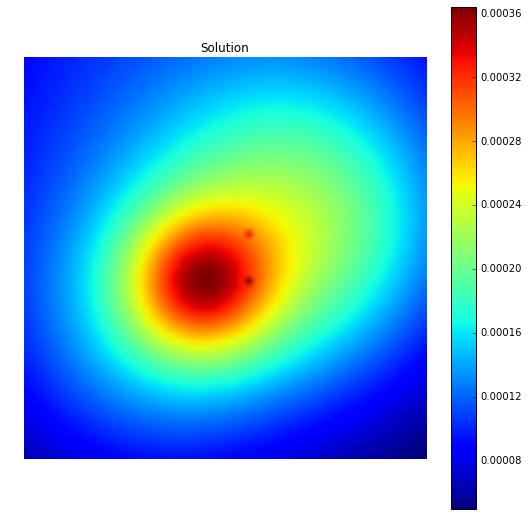

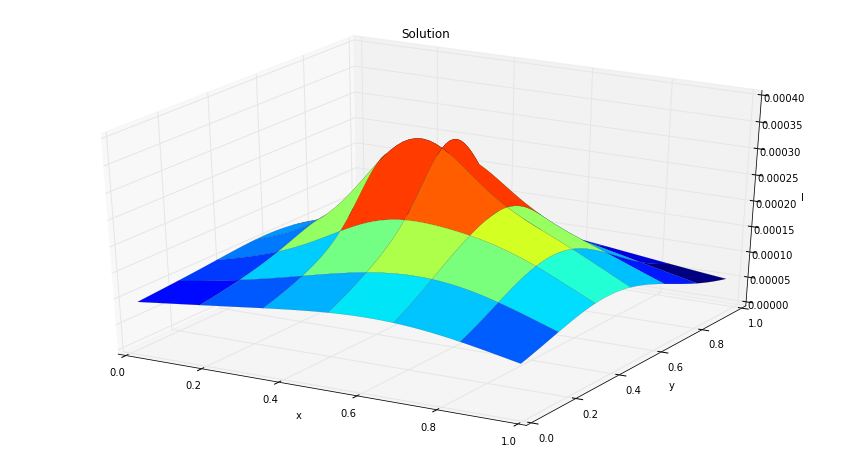

In [172]:
plot_sol(opt_c, opt_sig, xc, yc)